# POC work on statsmodels logistic regression

POC on statsmodels Logistic Regression including
1. Training the model
2. Pulling predictions
3. Basic evaluation metrics
4. Wrapping Logistic Regression statsmodel into an sklearn Pipeline

In [1]:
import statsmodels.api as sm
import pandas as pd
import numpy as np
import seaborn as sns
import scipy

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.pipeline import Pipeline

from sklearn.metrics import (
    roc_auc_score, 
    recall_score, 
    accuracy_score, 
    precision_score,
    confusion_matrix,
    roc_curve
)

# To help when Jupyter Notebook autocomplete is really slow
%config Completer.use_jedi = False

In [2]:
obs = 100000
population_df = (
    # Make columns of noise
    pd.DataFrame(np.random.rand(obs, 3), columns=[f"f{i}" for i in range(3)])
    .assign(target_class=np.random.rand(obs, 1) > 0.5)
    # Make columns that can help predict the target
    .assign(f3=lambda p_df: p_df.target_class.apply(lambda tc: tc + np.random.standard_normal()))
)
population_df.head()

,f0,f1,f2,target_class,f3
0,0.563966,0.400907,0.805757,True,0.752068
1,0.433904,0.983748,0.786890,True,1.883903
2,0.724375,0.433893,0.689766,True,0.638651
3,0.922347,0.695168,0.379019,True,1.544059
4,0.531899,0.343163,0.749126,True,-0.456940


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    population_df.drop(columns=['target_class']), 
    population_df.target_class, 
    test_size=0.2, random_state=42)

In [4]:
# By default there is no intercept but can be added into the X_train as a column of 1's
logit_mod = sm.Logit(y_train, X_train)
logit_mod_fit = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.585264
         Iterations 5


In [5]:
logit_mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           target_class   No. Observations:                80000
Model:                          Logit   Df Residuals:                    79996
Method:                           MLE   Df Model:                            3
Date:                Sat, 26 Oct 2019   Pseudo R-squ.:                  0.1556
Time:                        11:56:00   Log-Likelihood:                -46821.
converged:                       True   LL-Null:                       -55452.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
f0            -0.2539      0.023    -11.022      0.000      -0.299      -0.209
f1            -0.2949      0.023    -12.829      0.000      -0.340      -0.250
f2            -0.3179      0.023    -13.860      0.000      -0.363      -0.273
f3             0.9657      0.009    113.243      0.000       0.949       0.982
==============================================================================
"""

In [6]:
# Be default these are the probability of target_class == True
# For not just use the standard cutoff of 0.5
predictions = logit_mod_fit.predict(X_test) > 0.5

In [7]:
print(f"recall: {recall_score(y_test, predictions)}")
print(f"accuracy: {accuracy_score(y_test, predictions)}")
print(f"precision: {precision_score(y_test, predictions)}")
print(f"ROC: {roc_auc_score(y_test, predictions)}")

recall: 0.7117476794091226
accuracy: 0.6922
precision: 0.6857390133666699
ROC: 0.6921627887076672


In [8]:
display(pd.DataFrame(confusion_matrix(y_test, predictions), index=[False, True], columns=[False, True]))

,False,True
False,6713,3268
True,2888,7131


Text(0.5, 1.0, 'ROC Curve for Logistic Regression model')

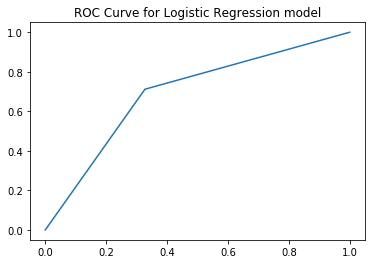

In [9]:
fpr, tpr, _ = roc_curve(y_test, predictions)

ax = sns.lineplot(x=fpr, y=tpr)
ax.set_title('ROC Curve for Logistic Regression model')

# Wrap the Logit predictor in an sklearn Pipeline

In [10]:
class SMWrapper(BaseEstimator, RegressorMixin):
    """ A universal sklearn-style wrapper for statsmodels regressors """
    def __init__(self, model_class, fit_intercept=True):
        self.model_class = model_class
        self.fit_intercept = fit_intercept
    def fit(self, X, y):
        if isinstance(X, scipy.sparse.csr.csr_matrix):
            X = X.todense()  # statsmodels has trouble with csr_matrix
        if self.fit_intercept:
            X = sm.add_constant(X)
        self.model_ = self.model_class(y, X)
        self.results_ = self.model_.fit()
    def predict(self, X):
        if self.fit_intercept:
            X = sm.add_constant(X)
        return self.results_.predict(X)

In [11]:
pipeline_logit_model = Pipeline(
    steps=[
        ('classifier', SMWrapper(sm.Logit, fit_intercept=False))
    ])

pipeline_logit_model.fit(X_train, y_train)

Optimization terminated successfully.
         Current function value: 0.585264
         Iterations 5


Pipeline(memory=None,
         steps=[('classifier',
                 SMWrapper(fit_intercept=False,
                           model_class=<class 'statsmodels.discrete.discrete_model.Logit'>))],
         verbose=False)

In [12]:
pl_predictions = pipeline_logit_model.predict(X_test) > 0.5

In [13]:
assert all(pl_predictions == predictions), 'Base predictions without the pipeline should match these predictions'